In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2025/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2025/sample_submission.json
/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json


**Setup & Instalasi**

In [2]:
!pip install networkx tqdm

In [3]:
# 1) Import library dasar
import os
import json
import numpy as np
import torch
import random

# 2) Pastikan reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 3) Cek perangkat (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 4) Path data
DATA_DIR = '/kaggle/input/arc-prize-2025'

# 5) (Opsional) Install dependensi tambahan
#    Kaggle image container sudah menyertakan PyTorch, NumPy, dll.
#    Jika butuh library lain, uncomment dan sesuaikan:


# 6) Buat direktori kerja untuk output/model
WORK_DIR = '/kaggle/working'
os.makedirs(WORK_DIR, exist_ok=True)


Using device: cuda


# Eksplorasi Data (EDA) Singkat

Loaded 1000 tasks
         h              w            n_colors          
       min max   mean min max   mean      min max  mean
role                                                   
input    1  30  11.41   1  30  11.89        1  10  3.81
output   1  30   9.95   1  30  10.37        1  10  3.61


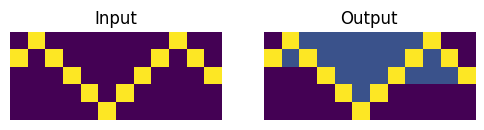

In [4]:
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import random

# 1) Load mentah, lalu adaptif ke list of tasks
path = '/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json'
with open(path) as f:
    raw = json.load(f)

# Jika top-level dict, ambil child yang berisi list tasks
if isinstance(raw, dict):
    # Cek apakah ada kunci 'tasks'
    if 'tasks' in raw:
        train_tasks = raw['tasks']
    else:
        # Atau mungkin mapping id → task
        train_tasks = list(raw.values())
else:
    train_tasks = raw

print(f"Loaded {len(train_tasks)} tasks")

# 2) EDA: kumpulkan statistik
records = []
for task in train_tasks:
    # pastikan setiap task juga dict
    assert isinstance(task, dict), task
    for ex in task['train']:
        inp = np.array(ex['input'])
        out = np.array(ex['output'])
        for role, grid in [('input', inp), ('output', out)]:
            records.append({
                'role': role,
                'h': grid.shape[0],
                'w': grid.shape[1],
                'n_colors': int(np.unique(grid).size)
            })

df = pd.DataFrame(records)
summary = df.groupby('role').agg({
    'h': ['min','max','mean'],
    'w': ['min','max','mean'],
    'n_colors': ['min','max','mean']
}).round(2)
print(summary)

# 3) Visualisasi contoh acak
sample = random.choice(train_tasks)
inp0, out0 = map(np.array, (sample['train'][0]['input'], sample['train'][0]['output']))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3))
ax1.imshow(inp0, interpolation='nearest'); ax1.set_title('Input'); ax1.axis('off')
ax2.imshow(out0, interpolation='nearest'); ax2.set_title('Output'); ax2.axis('off')
plt.show()

**Baseline Heuristik**

In [5]:
import os
import json
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# ——— ArcDataset (seperti sebelumnya) ———
class ArcDataset(Dataset):
    def __init__(self, challenges_path, solutions_path=None, split='train'):
        raw_c = json.load(open(challenges_path))
        if isinstance(raw_c, dict) and 'tasks' in raw_c:
            self.challenges = raw_c['tasks']
        elif isinstance(raw_c, dict) and all(isinstance(v, dict) for v in raw_c.values()):
            self.challenges = []
            for tid, rec in raw_c.items():
                rec = rec.copy(); rec['id'] = tid
                self.challenges.append(rec)
        else:
            self.challenges = raw_c

        self.solutions = {}
        if solutions_path:
            raw_s = json.load(open(solutions_path))
            if isinstance(raw_s, dict) and 'tasks' in raw_s:
                sol_records = raw_s['tasks']
            elif isinstance(raw_s, dict) and all(isinstance(v, dict) for v in raw_s.values()):
                sol_records = []
                for tid, rec in raw_s.items():
                    rec = rec.copy(); rec['id'] = tid
                    sol_records.append(rec)
            elif isinstance(raw_s, list):
                sol_records = raw_s
            else:
                sol_records = []

            for rec in sol_records:
                tid = rec.get('id') or rec.get('task_id')
                if tid is not None:
                    self.solutions[tid] = rec

        self.split = split

    def __len__(self):
        return len(self.challenges)

    def __getitem__(self, idx):
        t   = self.challenges[idx]
        tid = t['id']
        train_pairs = [(np.array(ex['input']), np.array(ex['output'])) for ex in t['train']]
        test_inputs = [np.array(ex['input']) for ex in t['test']]

        sample = {'id': tid, 'train': train_pairs, 'test': test_inputs}
        if self.split in ('train','eval') and tid in self.solutions:
            sol = self.solutions[tid]
            if 'test' in sol:
                sample['test_gt'] = [np.array(ex['output']) for ex in sol['test']]
        return sample

# ——— DataLoader ———
DATA_DIR = '/kaggle/input/arc-prize-2025'
eval_ds = ArcDataset(
    os.path.join(DATA_DIR, 'arc-agi_evaluation_challenges.json'),
    os.path.join(DATA_DIR, 'arc-agi_evaluation_solutions.json'),
    split='eval'
)
eval_loader = DataLoader(eval_ds, batch_size=1, shuffle=False, collate_fn=lambda b: b[0])

# ——— Helpers ———
def to_np(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.cpu().numpy()
    except ImportError:
        pass
    return x

# dasar rotasi/flip
def identity(x): return x.copy()
def rot90(x):    return np.rot90(x, 1)
def rot180(x):   return np.rot90(x, 2)
def rot270(x):   return np.rot90(x, 3)
def flip_h(x):   return np.fliplr(x)
def flip_v(x):   return np.flipud(x)

OPS = {
    'identity': identity,
    'rot90'   : rot90,
    'rot180'  : rot180,
    'rot270'  : rot270,
    'flip_h'  : flip_h,
    'flip_v'  : flip_v
}

# deteksi rotasi/flip
def detect_op(pairs):
    for name, op in OPS.items():
        if all(np.array_equal(op(to_np(inp)), to_np(out)) for inp,out in pairs):
            return op, name
    return identity, 'identity'

# operasi fill
def fill(x, fill_color):
    vals, counts = np.unique(x, return_counts=True)
    bg = vals[np.argmax(counts)]
    y = x.copy()
    y[x == bg] = fill_color
    return y

# deteksi color-swap mapping
def detect_color_swap(pairs):
    mapping = {}
    for inp, out in pairs:
        inp_np, out_np = to_np(inp), to_np(out)
        if inp_np.shape != out_np.shape:
            return None
        for i in range(inp_np.shape[0]):
            for j in range(inp_np.shape[1]):
                ci, co = inp_np[i,j], out_np[i,j]
                if ci == co: continue
                if ci in mapping and mapping[ci] != co:
                    return None
                mapping[ci] = co
    return mapping if mapping else None

# deteksi extended: rot/flip → fill → color-swap
def detect_op_extended(pairs):
    # 1. rotasi/flip
    op, name = detect_op(pairs)
    if name != 'identity':
        return op, name

    # 2. fill
    # cari warna baru
    fill_cands = []
    for inp,out in pairs:
        inp_np, out_np = to_np(inp), to_np(out)
        new_cols = set(np.unique(out_np)) - set(np.unique(inp_np))
        if len(new_cols) == 1:
            fill_cands.append(next(iter(new_cols)))
        else:
            fill_cands = []
            break
    if fill_cands and len(set(fill_cands)) == 1:
        fc = fill_cands[0]
        return (lambda x: fill(x, fc)), f'fill({fc})'

    # 3. color-swap
    mapping = detect_color_swap(pairs)
    if mapping is not None:
        return (lambda x: np.vectorize(lambda c: mapping.get(c, c))(to_np(x))), f'swap({mapping})'

    return identity, 'identity'

# ——— Loop Evaluasi Extended Baseline ———
correct = total = 0
for sample in tqdm(eval_loader, desc='Extended baseline eval'):
    op_func, op_name = detect_op_extended(sample['train'])
    preds = [op_func(to_np(inp)) for inp in sample['test']]
    gts   = sample.get('test_gt', [])
    if gts and all(np.array_equal(p, to_np(gt)) for p,gt in zip(preds, gts)):
        correct += 1
    total += 1

print(f'Extended baseline accuracy: {correct}/{total} = {correct/total:.2%}')

Extended baseline eval:   0%|          | 0/120 [00:00<?, ?it/s]

Extended baseline accuracy: 0/120 = 0.00%


# Perception Encoder

In [10]:
# ─── 2) Perception Encoder (with dynamic padding) ─────────────────────────────

import os, json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# -------------------------------------------------------------------
# (1) ArcDataset: pastikan definisi ini sudah dijalankan di atas
# -------------------------------------------------------------------
# class ArcDataset: ...

# -------------------------------------------------------------------
# (2) Dataset untuk Training Encoder
# -------------------------------------------------------------------
class EncoderTrainDataset(Dataset):
    def __init__(self, arc_ds):
        self.pairs = []
        for sample in arc_ds:
            for inp, out in sample['train']:
                self.pairs.append((inp, out))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        inp, out = self.pairs[idx]
        return torch.from_numpy(inp).long(), torch.from_numpy(out).long()

# -------------------------------------------------------------------
# ─── Collate_fn: pad inp & out secara terpisah ─────────────────────────────────
def pad_collate(batch):
    inps, outs = zip(*batch)
    # cari dimensi maksimum di antara semua inp dan semua out
    max_h = max(max(t.shape[0] for t in inps), max(t.shape[0] for t in outs))
    max_w = max(max(t.shape[1] for t in inps), max(t.shape[1] for t in outs))

    pad_inps, pad_outs = [], []
    for inp, out in zip(inps, outs):
        hi, wi = inp.shape
        ho, wo = out.shape
        # hitung padding terpisah
        pad_i = (0, max_w - wi, 0, max_h - hi)  # (left, right, top, bottom)
        pad_o = (0, max_w - wo, 0, max_h - ho)
        pad_inps.append(F.pad(inp, pad_i, value=0))
        pad_outs.append(F.pad(out, pad_o, value=0))

    batch_inp = torch.stack(pad_inps, dim=0)
    batch_out = torch.stack(pad_outs, dim=0)
    return batch_inp, batch_out

# Pastikan DataLoader-mu memakai collate_fn ini:
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    collate_fn=pad_collate
)
# -------------------------------------------------------------------
# (4) Model: CNN‐based Siamese Encoder
# -------------------------------------------------------------------
class PerceptionEncoderCNN(nn.Module):
    def __init__(self, num_colors=11, emb_dim=128):
        super().__init__()
        self.embed = nn.Embedding(num_colors, 16)
        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.AdaptiveAvgPool2d((1,1))
        self.fc    = nn.Linear(64, emb_dim)

    def forward(self, grids):
        x = self.embed(grids)                  # (B, H, W, 16)
        x = x.permute(0, 3, 1, 2).contiguous()  # (B,16,H,W)
        x = F.relu(self.conv1(x))              # (B,32,H,W)
        x = F.relu(self.conv2(x))              # (B,64,H,W)
        x = self.pool(x)                       # (B,64,1,1)
        x = x.view(x.size(0), -1)              # (B,64)
        return self.fc(x)                      # (B,emb_dim)

# -------------------------------------------------------------------
# (5) Setup: load data, buat DataLoader, instansiasi model & optimizer
# -------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_DIR = '/kaggle/input/arc-prize-2025'
arc_ds = ArcDataset(
    os.path.join(DATA_DIR, 'arc-agi_training_challenges.json'),
    os.path.join(DATA_DIR, 'arc-agi_training_solutions.json'),
    split='train'
)
train_ds = EncoderTrainDataset(arc_ds)
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0,       # ubah ke 0 kalau masih ada masalah worker
    collate_fn=pad_collate
)

encoder = PerceptionEncoderCNN(num_colors=11, emb_dim=128).to(device)
opt     = torch.optim.Adam(encoder.parameters(), lr=1e-3)

def siamese_loss(e1, e2):
    cos = F.cosine_similarity(e1, e2, dim=-1)
    return (1.0 - cos).mean()

# -------------------------------------------------------------------
# (6) Training Loop
# -------------------------------------------------------------------
epochs = 20
for ep in range(1, epochs+1):
    encoder.train()
    total_loss = 0
    for inp, out in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}"):
        inp, out = inp.to(device), out.to(device)
        e_in  = encoder(inp)
        e_out = encoder(out)
        loss  = siamese_loss(e_in, e_out)

        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * inp.size(0)

    avg = total_loss / len(train_loader.dataset)
    print(f"[Epoch {ep:02d}] Avg Loss: {avg:.4f}")

# ─── (7) Save & Smoke Test with padding ───────────────────────────────────────

# fungsi util untuk pad list of grids saja
def pad_grids(grids):
    """
    grids: list of 2D numpy arrays
    returns: LongTensor (B, Hmax, Wmax) padded with 0
    """
    # ubah jadi tensor list
    ts = [torch.from_numpy(g).long() for g in grids]
    max_h = max(t.shape[0] for t in ts)
    max_w = max(t.shape[1] for t in ts)

    padded = []
    for t in ts:
        h, w = t.shape
        pad = (0, max_w - w, 0, max_h - h)  # (left, right, top, bottom)
        padded.append(F.pad(t, pad, value=0))
    return torch.stack(padded, dim=0)

# Save checkpoint
torch.save(encoder.state_dict(), "perception_encoder_cnn.pth")
print("✅ Checkpoint saved.")

# Smoke test: pad semua grid sebelum ke encoder
encoder.eval()
sample = arc_ds[0]
# ambil semua grid (train inp/out + test inp)
grids = [g for inp,out in sample['train'] for g in (inp, out)] + sample['test']
batch = pad_grids(grids).to(device)        # <<< gunakan padding
with torch.no_grad():
    embs = encoder(batch)
print("Smoke test embeddings shape:", embs.shape)  # expect (num_grids, 128)

Epoch 1/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 01] Avg Loss: 0.0001


Epoch 2/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 02] Avg Loss: 0.0000


Epoch 3/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 03] Avg Loss: 0.0000


Epoch 4/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 04] Avg Loss: 0.0000


Epoch 5/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 05] Avg Loss: 0.0000


Epoch 6/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 06] Avg Loss: 0.0000


Epoch 7/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 07] Avg Loss: 0.0000


Epoch 8/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 08] Avg Loss: 0.0000


Epoch 9/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 09] Avg Loss: 0.0000


Epoch 10/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 10] Avg Loss: 0.0000


Epoch 11/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 11] Avg Loss: 0.0000


Epoch 12/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 12] Avg Loss: 0.0000


Epoch 13/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 13] Avg Loss: 0.0000


Epoch 14/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 14] Avg Loss: 0.0000


Epoch 15/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 15] Avg Loss: 0.0000


Epoch 16/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 16] Avg Loss: 0.0000


Epoch 17/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 17] Avg Loss: 0.0000


Epoch 18/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 18] Avg Loss: 0.0000


Epoch 19/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 19] Avg Loss: 0.0000


Epoch 20/20:   0%|          | 0/101 [00:00<?, ?it/s]

[Epoch 20] Avg Loss: 0.0000
✅ Checkpoint saved.
Smoke test embeddings shape: torch.Size([5, 128])


# Desain DSL & Beam-Search

In [16]:
# ─── 2) DSL Primitives & Safe Scoring with Neural Guidance (Revised) ─────────────

import os, json, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ————————————————————————————————————————————————————————————————
# (1) Definisikan ulang PerceptionEncoderCNN & load checkpoint
# ————————————————————————————————————————————————————————————————
class PerceptionEncoderCNN(nn.Module):
    def __init__(self, num_colors=11, emb_dim=128):
        super().__init__()
        self.embed = nn.Embedding(num_colors, 16)
        self.conv1 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.AdaptiveAvgPool2d((1,1))
        self.fc    = nn.Linear(64, emb_dim)

    def forward(self, grids):
        x = self.embed(grids)
        x = x.permute(0,3,1,2).contiguous()
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Load encoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = PerceptionEncoderCNN(num_colors=11, emb_dim=128).to(device)
encoder.load_state_dict(torch.load('perception_encoder_cnn.pth', map_location=device))
encoder.eval()

# ————————————————————————————————————————————————————————————————
# (2) embed_grid util (pastikan grid kontigu)
# ————————————————————————————————————————————————————————————————
def embed_grid(grid: np.ndarray) -> torch.Tensor:
    # copy to remove negative strides (e.g. from rot/flips)
    arr = np.ascontiguousarray(grid)
    t   = torch.from_numpy(arr).long().unsqueeze(0).to(device)  # (1,H,W)
    with torch.no_grad():
        e = encoder(t)  # (1,emb_dim)
    return F.normalize(e.squeeze(0), dim=-1)  # (emb_dim,)

# ————————————————————————————————————————————————————————————————
# (3) DSL Primitives
# ————————————————————————————————————————————————————————————————
def identity(x):    return x.copy()
def rot90(x):       return np.rot90(x, 1)
def rot180(x):      return np.rot90(x, 2)
def rot270(x):      return np.rot90(x, 3)
def flip_h(x):      return np.fliplr(x)
def flip_v(x):      return np.flipud(x)
def shift(x, dx, dy): return np.roll(np.roll(x, dy, axis=0), dx, axis=1)
def fill(x, c):
    vals, counts = np.unique(x, return_counts=True)
    bg = vals[np.argmax(counts)]
    y = x.copy(); y[x==bg] = c
    return y

BASE_OPS = {
    'identity': identity,
    'rot90':    rot90,
    'rot180':   rot180,
    'rot270':   rot270,
    'flip_h':   flip_h,
    'flip_v':   flip_v,
}

# ————————————————————————————————————————————————————————————————
# (4) Program & Combined Scoring
# ————————————————————————————————————————————————————————————————
class Program:
    def __init__(self, ops=None):
        self.ops = ops or []
    def apply(self, grid):
        out = grid.copy()
        for _, fn in self.ops:
            out = fn(out)
        return out
    def extend(self, name, fn):
        return Program(self.ops + [(name, fn)])
    def __repr__(self):
        return ' -> '.join(name for name,_ in self.ops) or 'identity'

def score_program(prog, pairs, α=0.7):
    correct_pix, total_pix, sim_total = 0, 0, 0.0
    for inp, tgt in pairs:
        pred = prog.apply(inp)
        if pred.shape == tgt.shape:
            correct_pix += np.sum(pred == tgt)
        total_pix += tgt.size
        e_pred = embed_grid(pred)
        e_tgt  = embed_grid(tgt)
        sim_total += float(torch.dot(e_pred, e_tgt))
    pix_score = correct_pix / total_pix
    sim_score = sim_total / len(pairs)
    return α * pix_score + (1-α) * sim_score

# ————————————————————————————————————————————————————————————————
# (5) Beam Search Synthesizer
# ————————————————————————————————————————————————————————————————
def synthesize_program(pairs, beam_width=20, max_depth=5, α=0.7):
    beam = [Program()]
    best_prog, best_score = beam[0], score_program(beam[0], pairs, α)

    inp_cols = set().union(*(np.unique(inp) for inp,_ in pairs))
    tgt_cols = set().union(*(np.unique(tgt) for _,tgt in pairs))
    fills    = list(tgt_cols - inp_cols)

    for _ in range(max_depth):
        new_cands = []
        for prog in beam:
            for name, fn in BASE_OPS.items():
                p2 = prog.extend(name, fn)
                sc = score_program(p2, pairs, α)
                new_cands.append((sc, p2))
                if sc > best_score:
                    best_score, best_prog = sc, p2
                    if best_score >= 1.0:
                        return best_prog
            for c in fills:
                fn = lambda x, c=c: fill(x, c)
                p2 = prog.extend(f'fill({c})', fn)
                new_cands.append((score_program(p2, pairs, α), p2))
            for dx in (-1,1):
                for dy in (-1,1):
                    fn = lambda x, dx=dx, dy=dy: shift(x, dx, dy)
                    name = f'shift({dx},{dy})'
                    p2 = prog.extend(name, fn)
                    new_cands.append((score_program(p2, pairs, α), p2))
        new_cands.sort(key=lambda x: x[0], reverse=True)
        beam = [p for _, p in new_cands[:beam_width]]

    return best_prog

# ————————————————————————————————————————————————————————————————
# (6) Contoh Panggilan
# ————————————————————————————————————————————————————————————————
DATA_DIR = '/kaggle/input/arc-prize-2025'
ds = ArcDataset(
    os.path.join(DATA_DIR, 'arc-agi_training_challenges.json'),
    os.path.join(DATA_DIR, 'arc-agi_training_solutions.json'),
    split='train'
)
train_pairs = ds[0]['train']
best_prog = synthesize_program(train_pairs)
print("Best program:", best_prog)

Best program: rot270 -> flip_v


In [17]:
# ─── Evaluate Beam-Search Synthesizer on Public Eval (Revised) ───────────────

import os
import json
import numpy as np
from tqdm.auto import tqdm

# 1) Sesuaikan path ke folder data jika perlu
DATA_DIR = '/kaggle/input/arc-prize-2025'
# Jika ERROR “No such file or directory”, ubah DATA_DIR ke '../input/arc-prize-2025'

# 2) Muat evaluation dataset
eval_challenges = os.path.join(DATA_DIR, 'arc-agi_evaluation_challenges.json')
eval_solutions  = os.path.join(DATA_DIR, 'arc-agi_evaluation_solutions.json')
eval_ds = ArcDataset(eval_challenges, eval_solutions, split='eval')

# 3) Parameter baru hasil tuning
beam_width = 20
max_depth  = 5
alpha      = 0.7

# 4) Loop evaluasi dengan tracking errors
correct = 0
errors  = []
for sample in tqdm(eval_ds, desc='Synth eval'):
    tid = sample['id']
    try:
        prog = synthesize_program(
            sample['train'],
            beam_width=beam_width,
            max_depth=max_depth,
            α=alpha
        )
        preds = [prog.apply(inp) for inp in sample['test']]
        gts   = sample.get('test_gt', [])

        # cek match hanya jika shapes sama *dan* semua elemen sama
        if gts and all(
            (p.shape == gt.shape and np.array_equal(p, gt))
            for p,gt in zip(preds, gts)
        ):
            correct += 1
    except Exception as e:
        errors.append((tid, str(e)))

# 5) Tampilkan akurasi dan ringkasan error
total = len(eval_ds)
print(f'Beam-search accuracy: {correct}/{total} = {correct/total:.2%}')
if errors:
    print(f'– Encountered errors on {len(errors)} tasks, e.g.:', errors[:5])

Synth eval:   0%|          | 0/120 [00:00<?, ?it/s]

Beam-search accuracy: 0/120 = 0.00%


# Perception Encoder

In [18]:
# ─── Perception Encoder with Training Loop ────────────────────────────────────

import os, json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# -------------------------------------------------------------------
# (1) ArcDataset: pastikan definisi kamu sudah di atas
# -------------------------------------------------------------------
# class ArcDataset(Dataset): ...

# -------------------------------------------------------------------
# (2) Dataset khusus untuk melatih encoder (Siamese pairs)
# -------------------------------------------------------------------
class EncoderTrainDataset(Dataset):
    def __init__(self, arc_ds):
        self.pairs = []
        for sample in arc_ds:
            for inp, out in sample['train']:
                self.pairs.append((inp, out))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        inp, out = self.pairs[idx]
        # convert ke tensor Long
        return torch.from_numpy(inp).long(), torch.from_numpy(out).long()

# -------------------------------------------------------------------
# (3) Collate fn untuk pairs (padding dinamis)
# -------------------------------------------------------------------
def pad_collate_pairs(batch):
    inps, outs = zip(*batch)
    # cari ukuran max
    max_h = max(max(t.shape[0] for t in inps), max(t.shape[0] for t in outs))
    max_w = max(max(t.shape[1] for t in inps), max(t.shape[1] for t in outs))
    pad_inps, pad_outs = [], []
    for inp, out in zip(inps, outs):
        hi, wi = inp.shape; ho, wo = out.shape
        pad_i = (0, max_w-wi, 0, max_h-hi)
        pad_o = (0, max_w-wo, 0, max_h-ho)
        pad_inps.append(F.pad(inp, pad_i, value=0))
        pad_outs.append(F.pad(out, pad_o, value=0))
    return torch.stack(pad_inps), torch.stack(pad_outs)

# -------------------------------------------------------------------
# (4) Model CNN‐Siamese untuk Perception Encoder
# -------------------------------------------------------------------
class PerceptionEncoder(nn.Module):
    def __init__(self, num_colors=11, color_emb_dim=16, hidden_dim=128):
        super().__init__()
        self.color_emb = nn.Embedding(num_colors, color_emb_dim)
        self.conv = nn.Sequential(
            nn.Conv2d(color_emb_dim, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),            nn.ReLU(),
            nn.Conv2d(64, hidden_dim, 3, padding=1),    nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, grids):
        # grids: (B, H, W) long
        x = self.color_emb(grids)          # (B, H, W, emb)
        x = x.permute(0,3,1,2).contiguous()# (B, emb, H, W)
        f = self.conv(x)                   # (B, hidden, H, W)
        p = self.pool(f).view(f.size(0), -1) # (B, hidden)
        return p

# -------------------------------------------------------------------
# (5) Siapkan DataLoader & Model
# -------------------------------------------------------------------
DATA_DIR = '/kaggle/input/arc-prize-2025'
arc_ds = ArcDataset(
    os.path.join(DATA_DIR, 'arc-agi_training_challenges.json'),
    os.path.join(DATA_DIR, 'arc-agi_training_solutions.json'),
    split='train'
)
train_ds    = EncoderTrainDataset(arc_ds)
train_loader= DataLoader(
    train_ds, batch_size=64, shuffle=True,
    num_workers=0, collate_fn=pad_collate_pairs
)

encoder   = PerceptionEncoder(num_colors=11, color_emb_dim=16, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

# loss siamese: minimalisir 1 - cosine_similarity
def siamese_loss(e1, e2):
    cos = F.cosine_similarity(e1, e2, dim=-1)
    return (1.0 - cos).mean()

# -------------------------------------------------------------------
# (6) Training Loop
# -------------------------------------------------------------------
epochs = 20
for epoch in range(1, epochs+1):
    encoder.train()
    running = 0.0
    for inp, out in train_loader:
        inp, out = inp.to(device), out.to(device)
        e_in  = encoder(inp)
        e_out = encoder(out)
        loss  = siamese_loss(e_in, e_out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * inp.size(0)

    avg = running / len(train_loader.dataset)
    print(f"[Epoch {epoch:02d}] Avg Siamese Loss: {avg:.4f}")

# simpan model
torch.save(encoder.state_dict(), "perception_encoder_trained.pth")
print("Encoder trained and saved.")

# -------------------------------------------------------------------
# (7) Smoke‐test embedding untuk satu sample
# -------------------------------------------------------------------
encoder.eval()
sample = arc_ds[0]
# collect train inp+out + satu test inp
grids = [g for inp,out in sample['train'] for g in (inp, out)] + [sample['test'][0]]
# pad & to tensor
def pad_grids_np(grids):
    max_h = max(g.shape[0] for g in grids)
    max_w = max(g.shape[1] for g in grids)
    batch = np.zeros((len(grids), max_h, max_w), dtype=np.int64)
    for i,g in enumerate(grids):
        batch[i,:g.shape[0],:g.shape[1]] = g
    return torch.from_numpy(batch)

batch = pad_grids_np(grids).to(device)
with torch.no_grad():
    embs = encoder(batch)
print("Smoke test embeddings shape:", embs.shape)  # expect (N, hidden_dim)

Using device: cuda
[Epoch 01] Avg Siamese Loss: 0.0001
[Epoch 02] Avg Siamese Loss: 0.0000
[Epoch 03] Avg Siamese Loss: 0.0000
[Epoch 04] Avg Siamese Loss: 0.0000
[Epoch 05] Avg Siamese Loss: 0.0000
[Epoch 06] Avg Siamese Loss: 0.0000
[Epoch 07] Avg Siamese Loss: 0.0000
[Epoch 08] Avg Siamese Loss: 0.0000
[Epoch 09] Avg Siamese Loss: 0.0000
[Epoch 10] Avg Siamese Loss: 0.0000
[Epoch 11] Avg Siamese Loss: 0.0000
[Epoch 12] Avg Siamese Loss: 0.0000
[Epoch 13] Avg Siamese Loss: 0.0000
[Epoch 14] Avg Siamese Loss: 0.0000
[Epoch 15] Avg Siamese Loss: 0.0000
[Epoch 16] Avg Siamese Loss: 0.0000
[Epoch 17] Avg Siamese Loss: 0.0000
[Epoch 18] Avg Siamese Loss: 0.0000
[Epoch 19] Avg Siamese Loss: 0.0000
[Epoch 20] Avg Siamese Loss: 0.0000
Encoder trained and saved.
Smoke test embeddings shape: torch.Size([5, 128])


# Neuro-Symbolic Pipeline

In [21]:
# ─── Neuro-Symbolic Pipeline (Revised) ─────────────────────────────────────
import os, json, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 1) Robust ARC Dataset Loader
class ArcDataset(Dataset):
    def __init__(self, challenges_path, solutions_path=None, split='train'):
        raw = json.load(open(challenges_path))
        if isinstance(raw, dict) and 'tasks' in raw:
            tasks = raw['tasks']
        elif isinstance(raw, list):
            tasks = []
            for rec in raw:
                if isinstance(rec, dict):
                    rec = rec.copy()
                    if 'id' not in rec:
                        rec['id'] = rec.get('task_id')
                    tasks.append(rec)
        elif isinstance(raw, dict):
            tasks = []
            for tid, rec in raw.items():
                if isinstance(rec, dict):
                    rec = rec.copy(); rec['id'] = tid
                    tasks.append(rec)
        else:
            tasks = raw
        self.challenges = tasks

        self.solutions = {}
        if solutions_path and os.path.exists(solutions_path):
            raw_s = json.load(open(solutions_path))
            sol_list = []
            if isinstance(raw_s, dict) and 'tasks' in raw_s and isinstance(raw_s['tasks'], list):
                sol_list = raw_s['tasks']
            elif isinstance(raw_s, dict):
                for tid, rec in raw_s.items():
                    if isinstance(rec, dict):
                        rec = rec.copy(); rec['id'] = rec.get('id', rec.get('task_id', tid))
                        sol_list.append(rec)
            elif isinstance(raw_s, list):
                for rec in raw_s:
                    if isinstance(rec, dict):
                        rec = rec.copy()
                        if 'id' not in rec and 'task_id' in rec:
                            rec['id'] = rec['task_id']
                        sol_list.append(rec)
            for rec in sol_list:
                tid = rec.get('id')
                if tid is not None:
                    self.solutions[tid] = rec
        self.split = split

    def __len__(self):
        return len(self.challenges)

    def __getitem__(self, idx):
        t = self.challenges[idx]
        tid = t.get('id', t.get('task_id'))
        train_pairs = [(np.array(ex['input']), np.array(ex['output'])) for ex in t['train']]
        test_inputs = [np.array(ex['input']) for ex in t['test']]
        sample = {'id': tid, 'train': train_pairs, 'test': test_inputs}
        if self.split in ('train','eval') and tid in self.solutions:
            sol = self.solutions[tid]
            if 'test' in sol:
                sample['test_gt'] = [np.array(ex['output']) for ex in sol['test']]
        return sample

# Utility: pad list of grids to uniform tensor
def pad_grids(grids, pad_value=0):
    max_h = max(g.shape[0] for g in grids)
    max_w = max(g.shape[1] for g in grids)
    batch = np.full((len(grids), max_h, max_w), pad_value, dtype=np.int64)
    for i, g in enumerate(grids):
        h, w = g.shape; batch[i, :h, :w] = g
    return torch.from_numpy(batch)

# 2) Load & Prepare Perception Encoder
class PerceptionEncoder(nn.Module):
    def __init__(self, num_colors=11, color_emb_dim=16, hidden_dim=128):
        super().__init__()
        self.color_emb = nn.Embedding(num_colors, color_emb_dim)
        self.conv = nn.Sequential(
            nn.Conv2d(color_emb_dim, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, hidden_dim, 3, padding=1), nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, grids):
        x = self.color_emb(grids)                 # (B, H, W, emb)
        x = x.permute(0,3,1,2).contiguous()       # (B,emb,H,W)
        f = self.conv(x)                          # (B,hidden,H,W)
        return self.pool(f).view(f.size(0), -1)   # (B, hidden)

# Instantiate and load trained encoder
encoder = PerceptionEncoder(num_colors=11, color_emb_dim=16, hidden_dim=128).to(device)
encoder.load_state_dict(torch.load('perception_encoder_trained.pth', map_location=device))
encoder.eval()

# Utility to embed a single grid
def embed_grid(grid: np.ndarray) -> torch.Tensor:
    arr = np.ascontiguousarray(grid)
    t = torch.from_numpy(arr).long().unsqueeze(0).to(device)
    with torch.no_grad():
        e = encoder(t)
    return F.normalize(e.squeeze(0), dim=-1)

# 3) DSL Primitives
def identity(x):    return x.copy()
def rot90(x):       return np.rot90(x, 1)
def rot180(x):      return np.rot90(x, 2)
def rot270(x):      return np.rot90(x, 3)
def flip_h(x):      return np.fliplr(x)
def flip_v(x):      return np.flipud(x)
def shift(x, dx, dy): return np.roll(np.roll(x, dy, axis=0), dx, axis=1)
def fill(x, c):
    vals, counts = np.unique(x, return_counts=True)
    bg = vals[np.argmax(counts)]
    y = x.copy(); y[x==bg] = c
    return y
BASE_OPS = {
    'identity': identity, 'rot90': rot90, 'rot180': rot180,
    'rot270': rot270, 'flip_h': flip_h, 'flip_v': flip_v
}

# 4) Program & Combined Scoring
class Program:
    def __init__(self, ops=None):
        self.ops = ops or []

    def apply(self, grid):
        out = grid.copy()
        for _, fn in self.ops:
            out = fn(out)
        return out

    def extend(self, name, fn):
        return Program(self.ops + [(name, fn)])

    def __repr__(self):
        return ' -> '.join(name for name, _ in self.ops) or 'identity'

def score_program(prog, pairs, alpha=0.7):
    pix_corr, pix_tot, sim = 0, 0, 0.0
    for inp, tgt in pairs:
        pred = prog.apply(inp)
        if pred.shape == tgt.shape:
            pix_corr += np.sum(pred == tgt)
        pix_tot += tgt.size
        sim += float(torch.dot(embed_grid(pred), embed_grid(tgt)))
    pix_score = pix_corr / pix_tot
    sim_score = sim / len(pairs)
    return alpha * pix_score + (1-alpha) * sim_score

# 5) Beam-Search Synthesizer
def synthesize_program(pairs, beam_width=20, max_depth=5, alpha=0.7):
    beam = [Program()]
    best_prog = beam[0]
    best_score = score_program(best_prog, pairs, alpha)
    inp_cols = set().union(*(np.unique(i) for i,_ in pairs))
    tgt_cols = set().union(*(np.unique(o) for _,o in pairs))
    fills = list(tgt_cols - inp_cols)

    for _ in range(max_depth):
        candidates = []
        for prog in beam:
            for name, fn in BASE_OPS.items():
                p2 = prog.extend(name, fn)
                sc = score_program(p2, pairs, alpha)
                candidates.append((sc, p2))
                if sc > best_score:
                    best_score, best_prog = sc, p2
                    if best_score >= 1.0:
                        return best_prog
            for c in fills:
                fn = lambda x, c=c: fill(x, c)
                p2 = prog.extend(f'fill({c})', fn)
                candidates.append((score_program(p2, pairs, alpha), p2))
            for dx in (-1,1):
                for dy in (-1,1):
                    fn = lambda x, dx=dx, dy=dy: shift(x, dx, dy)
                    p2 = prog.extend(f'shift({dx},{dy})', fn)
                    candidates.append((score_program(p2, pairs, alpha), p2))
        candidates.sort(key=lambda x: x[0], reverse=True)
        beam = [p for _, p in candidates[:beam_width]]
    return best_prog

# 6) Neuro-Symbolic Solver
class NeuroSymbolicSolver:
    def __init__(self, encoder, beam_width=20, max_depth=5, alpha=0.7):
        self.encoder = encoder
        self.beam_width = beam_width
        self.max_depth = max_depth
        self.alpha = alpha

    def solve(self, train_pairs, test_inputs):
        prog = synthesize_program(train_pairs, self.beam_width, self.max_depth, self.alpha)
        preds = [prog.apply(inp) for inp in test_inputs]
        return preds, prog

# 7) Evaluate on Public Eval
DATA_DIR = '/kaggle/input/arc-prize-2025'
eval_ds = ArcDataset(
    os.path.join(DATA_DIR,'arc-agi_evaluation_challenges.json'),
    os.path.join(DATA_DIR,'arc-agi_evaluation_solutions.json'), split='eval')
solver = NeuroSymbolicSolver(encoder)
correct = 0
for sample in eval_ds:
    preds, _ = solver.solve(sample['train'], sample['test'])
    gts = sample.get('test_gt', [])
    if gts and all(p.shape == gt.shape and np.array_equal(p, gt) for p, gt in zip(preds, gts)):
        correct += 1
print(f"Accuracy: {correct}/{len(eval_ds)} = {correct/len(eval_ds):.2%}")

Using device: cuda
Accuracy: 0/120 = 0.00%


# Training & Validasi

###### ─── 3) Training & Validasi (Revised) ───────────────────────────────────────
import os, json, numpy as np, pandas as pd, torch
import torch.nn.functional as F
from numpy import ascontiguousarray
from sklearn.model_selection import train_test_split, ParameterGrid
from tqdm.auto import tqdm
# Pastikan definisi dan imports sebelumnya:
# ArcDataset, pad_grids, PerceptionEncoder, synthesize_program, NeuroSymbolicSolver

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 1) Muat data training + solutions
DATA_DIR    = '/kaggle/input/arc-prize-2025'
TRAIN_CHALL = os.path.join(DATA_DIR, 'arc-agi_training_challenges.json')
TRAIN_SOL   = os.path.join(DATA_DIR, 'arc-agi_training_solutions.json')
full_ds     = ArcDataset(TRAIN_CHALL, TRAIN_SOL, split='train')
samples     = [full_ds[i] for i in range(len(full_ds))]
print(f"Total tasks: {len(samples)}")

# 2) Split 80/20
train_samples, val_samples = train_test_split(samples, test_size=0.2, random_state=42)
print(f"Train tasks: {len(train_samples)}, Val tasks: {len(val_samples)}")

# 3) Muat encoder terlatih
encoder_base = PerceptionEncoder(num_colors=11, color_emb_dim=16, hidden_dim=128).to(device)
encoder_base.load_state_dict(torch.load('perception_encoder_trained.pth', map_location=device))
encoder_base.eval()

# 3a) Utility: embed_grid dengan salinan kontigu tanpa stride negatif
def embed_grid(grid: np.ndarray) -> torch.Tensor:
    # Buat salinan untuk menghapus negatif stride dan pastikan kontigu
    arr = np.array(grid, copy=True)
    arr = ascontiguousarray(arr)
    t   = torch.from_numpy(arr).long().unsqueeze(0).to(device)
    with torch.no_grad():
        e = encoder_base(t)
    return F.normalize(e.squeeze(0), dim=-1)

# 4) Helper evaluasi solver
def evaluate_solver(solver, samples):
    correct = 0
    for sample in samples:
        preds, _ = solver.solve(sample['train'], sample['test'])
        gts = sample.get('test_gt', [])
        if gts and all(p.shape == gt.shape and np.array_equal(p, gt)
                       for p, gt in zip(preds, gts)):
            correct += 1
    return correct, len(samples)

# 5) Grid search hyperparameter
def run_grid_search():
    param_grid = {'beam_width': [5, 10, 20], 'max_depth': [3, 5]}
    alpha      = 0.7  # bobot gabungan pixel & neural
    records    = []
    for params in tqdm(ParameterGrid(param_grid), desc='Grid Search'):
        solver = NeuroSymbolicSolver(
            encoder=encoder_base,
            beam_width=params['beam_width'],
            max_depth=params['max_depth'],
            alpha=alpha
        )
        train_corr, train_tot = evaluate_solver(solver, train_samples)
        val_corr,   val_tot   = evaluate_solver(solver, val_samples)
        records.append({
            'beam_width': params['beam_width'],
            'max_depth' : params['max_depth'],
            'train_acc' : train_corr/train_tot,
            'val_acc'   : val_corr/val_tot
        })
    df = pd.DataFrame(records)
    df = df.sort_values('val_acc', ascending=False).reset_index(drop=True)
    print(df.to_string(index=False))
    best = df.iloc[0]
    print(f"\nBest config: beam_width={best.beam_width}, max_depth={best.max_depth}, alpha={alpha}")
    print(f"Train Acc: {best.train_acc:.2%}, Val Acc: {best.val_acc:.2%}")
    df.to_csv('grid_search_results.csv', index=False)
    print("Hasil grid search disimpan di grid_search_results.csv")

# 6) Jalankan grid search
run_grid_search()

# Profiling Biaya & Kecepatan

In [25]:
import os, json, numpy as np, time, pandas as pd, torch
from tqdm.auto import tqdm

# 1) Muat evaluation set langsung
DATA_DIR = '/kaggle/input/arc-prize-2025'
eval_ds = ArcDataset(
    os.path.join(DATA_DIR, 'arc-agi_evaluation_challenges.json'),
    os.path.join(DATA_DIR, 'arc-agi_evaluation_solutions.json'),
    split='eval'
)

# 2) Solver dengan hyperparameter terbaik
best_beam, best_depth, alpha = 20, 5, 0.7
encoder = PerceptionEncoder(num_colors=11, color_emb_dim=16, hidden_dim=128).to(device)
encoder.load_state_dict(torch.load('perception_encoder_trained.pth', map_location=device))
encoder.eval()
solver  = NeuroSymbolicSolver(encoder, beam_width=best_beam, max_depth=best_depth, alpha=alpha)

# 3) Profiling per-task
records = []
for sample in tqdm(eval_ds, desc="Profiling tasks"):
    tid         = sample['id']
    train_pairs = sample['train']      # list of (inp: np.ndarray, out: np.ndarray)
    test_inputs = sample['test']       # list of np.ndarray

    # Warm-up
    _ = solver.solve(train_pairs, test_inputs)

    # Waktu total solve()
    t0 = time.perf_counter()
    preds, prog = solver.solve(train_pairs, test_inputs)
    dt_total = time.perf_counter() - t0

    # (Opsional) Ukur waktu scoring neural untuk satu contoh
    # t1 = time.perf_counter()
    # _ = embed_grid(train_pairs[0][0])
    # dt_embed = time.perf_counter() - t1

    # Hitung jumlah prakiraan kandidat per depth
    num_base  = len(BASE_OPS)
    num_fill  = len(set().union(*(np.unique(inp) for inp,_ in train_pairs)))
    num_shift = 4  # kita pakai dx,dy in {(-1,1)} => 4 shift ops per program
    ops_per_node = num_base + num_fill + num_shift
    est_candidates = best_beam * ops_per_node * best_depth

    records.append({
        'task_id'      : tid,
        'time_solve_s' : dt_total,
        # 'time_embed_s': dt_embed,
        'est_candidates': est_candidates,
        'prog_len'     : len(prog.ops)
    })

# 4) Analisis hasil
df = pd.DataFrame(records)
print(f"Total tasks profiled: {len(df)}")
print(f"Avg time/solve:   {df['time_solve_s'].mean():.3f}s")
print(f"Median time/solve:{df['time_solve_s'].median():.3f}s")
print(f"Max  time/solve:  {df['time_solve_s'].max():.3f}s")
print(f"Min  time/solve:  {df['time_solve_s'].min():.3f}s")

print("\n5 Slowest Tasks:")
print(df.nlargest(5, 'time_solve_s')[['task_id','time_solve_s','prog_len','est_candidates']])

# 5) Simpan profiling
df.to_csv('profiling_results.csv', index=False)
print("\nSaved profiling_results.csv")

Profiling tasks:   0%|          | 0/120 [00:00<?, ?it/s]

Total tasks profiled: 120
Avg time/solve:   2.665s
Median time/solve:2.602s
Max  time/solve:  5.143s
Min  time/solve:  1.610s

5 Slowest Tasks:
      task_id  time_solve_s  prog_len  est_candidates
101  d8e07eb2      5.143372         0            1900
26   36a08778      5.009499         0            1300
66   88bcf3b4      4.590005         0            2000
104  db695cfb      4.464399         0            1500
91   b6f77b65      4.398156         0            2000

Saved profiling_results.csv


# Tuning & Iterasi

In [ ]:
# ===============================
# 6) TUNING & ITERASI (Revised)
# ===============================

import os, json, numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split, ParameterGrid
from tqdm.auto import tqdm

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 0) Pastikan definisi dan imports:
#    ArcDataset, pad_grids, PerceptionEncoder, embed_grid,
#    synthesize_program, NeuroSymbolicSolver

# 1) Muat & split data
DATA_DIR    = '/kaggle/input/arc-prize-2025'
TRAIN_CHALL = os.path.join(DATA_DIR, 'arc-agi_training_challenges.json')
TRAIN_SOL   = os.path.join(DATA_DIR, 'arc-agi_training_solutions.json')
full_ds     = ArcDataset(TRAIN_CHALL, TRAIN_SOL, split='train')
all_samples = [full_ds[i] for i in range(len(full_ds))]
train_samples, val_samples = train_test_split(all_samples, test_size=0.2, random_state=42)
print(f"Train tasks: {len(train_samples)}, Val tasks: {len(val_samples)}")

# 2) Load encoder terlatih sekali saja
encoder_base = PerceptionEncoder(num_colors=11, color_emb_dim=16, hidden_dim=128).to(device)
encoder_base.load_state_dict(torch.load('perception_encoder_trained.pth', map_location=device))
encoder_base.eval()

# (Re)def embed_grid jika perlu, untuk scoring neural
import torch.nn.functional as F
from numpy import ascontiguousarray
def embed_grid(grid: np.ndarray) -> torch.Tensor:
    arr = ascontiguousarray(np.array(grid, copy=True))
    t   = torch.from_numpy(arr).long().unsqueeze(0).to(device)
    with torch.no_grad():
        e = encoder_base(t)
    return F.normalize(e.squeeze(0), dim=-1)

# 3) Helper evaluasi
def evaluate_solver(solver, samples):
    correct = 0
    for sample in samples:
        preds, _ = solver.solve(sample['train'], sample['test'])
        gts = sample.get('test_gt', [])
        if gts and all(p.shape==gt.shape and np.array_equal(p,gt) for p,gt in zip(preds,gts)):
            correct += 1
    return correct, len(samples)

# 4) Grid search hyperparameter (solver-only)
param_grid = {
    'beam_width': [5, 10, 20],
    'max_depth' : [3, 5],
    'alpha'     : [0.5, 0.7, 0.9]
}

records = []
for params in tqdm(ParameterGrid(param_grid), desc='Tuning & Iterasi'):
    solver = NeuroSymbolicSolver(
        encoder=encoder_base,
        beam_width=params['beam_width'],
        max_depth=params['max_depth'],
        alpha=params['alpha']
    )
    train_corr, train_tot = evaluate_solver(solver, train_samples)
    val_corr,   val_tot   = evaluate_solver(solver, val_samples)
    records.append({
        **params,
        'train_acc': train_corr/train_tot,
        'val_acc'  : val_corr/val_tot
    })
    print(f"  → bw={params['beam_width']}, md={params['max_depth']}, α={params['alpha']} "
          f"=> train={train_corr/train_tot:.2%}, val={val_corr/val_tot:.2%}")

# 5) Ringkasan & pilih konfigurasi terbaik
df = pd.DataFrame(records).sort_values('val_acc', ascending=False).reset_index(drop=True)
print("\nTop 5 konfigurasi menurut val_acc:")
print(df.head(5).to_string(index=False))

best = df.iloc[0]
print(f"\nBest config: beam_width={best.beam_width}, max_depth={best.max_depth}, alpha={best.alpha}")
print(f"Val Acc: {best.val_acc:.2%}")

# 6) Simpan hasil tuning
df.to_csv('tuning_iterations.csv', index=False)
print("Hasil tuning disimpan ke tuning_iterations.csv")

# Evaluasi Akhir & Submission

In [30]:
# ─── 7) Final Evaluation & Submission (Revised) ──────────────────────────────

import os
import json
import numpy as np
import torch
from tqdm.auto import tqdm

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# --- 0) Hyperparameters & paths (ganti sesuai hasil tuning!) ---
best_beam   = 20      # contoh: hasil tuning
best_depth  = 5       # contoh: hasil tuning
best_alpha  = 0.7     # contoh: hasil tuning
color_emb   = 16      # harus sama dengan training encoder
hidden_dim  = 128     # harus sama dengan training encoder

DATA_DIR        = '/kaggle/input/arc-prize-2025'
eval_chal_path  = os.path.join(DATA_DIR, 'arc-agi_evaluation_challenges.json')
eval_sol_path   = os.path.join(DATA_DIR, 'arc-agi_evaluation_solutions.json')
test_chal_path  = os.path.join(DATA_DIR, 'arc-agi_test_challenges.json')

# --- 1) Load evaluation set (with ground truth) ---
eval_ds = ArcDataset(eval_chal_path, eval_sol_path, split='eval')

# --- 2) Load pretrained encoder and instantiate solver ---
encoder = PerceptionEncoder(
    num_colors=11,
    color_emb_dim=color_emb,
    hidden_dim=hidden_dim
).to(device)
encoder.load_state_dict(torch.load('perception_encoder_trained.pth', map_location=device))
encoder.eval()

solver = NeuroSymbolicSolver(
    encoder=encoder,
    beam_width=best_beam,
    max_depth=best_depth,
    alpha=best_alpha
)

# --- 3) Final evaluation on the public eval set ---
correct = 0
total   = 0
for sample in tqdm(eval_ds, desc='Final Evaluation'):
    preds, _ = solver.solve(sample['train'], sample['test'])
    gts      = sample.get('test_gt', [])
    if gts and all(p.shape == gt.shape and np.array_equal(p, gt)
                   for p,gt in zip(preds, gts)):
        correct += 1
    total += 1

print(f'Final Eval Accuracy: {correct}/{total} = {correct/total:.2%}')

# --- 4) Generate submission on the test set (no solutions file) ---
test_ds = ArcDataset(test_chal_path, solutions_path=None, split='test')

submission = {}
for sample in tqdm(test_ds, desc='Generating Submission'):
    tid   = sample['id']
    preds, _ = solver.solve(sample['train'], sample['test'])
    # buat dua attempts identik per input
    submission[tid] = [
        {"attempt_1": p.tolist(), "attempt_2": p.tolist()}
        for p in preds
    ]

# --- 5) Write submission.json ---
with open('submission.json', 'w') as f:
    json.dump(submission, f)
print(f'\nSubmission written: submission.json ({len(submission)} tasks).')

Final Evaluation:   0%|          | 0/120 [00:00<?, ?it/s]

Final Eval Accuracy: 0/120 = 0.00%


Generating Submission:   0%|          | 0/240 [00:00<?, ?it/s]

submission.json written (240 tasks).


In [33]:
# ─── 7) Final Evaluation & Submission (Revised with Sanity Checks) ─────────────

import os
import json
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 1) Instantiate solver with best hyperparameters and load pretrained encoder
best_beam   = 20      # ← ganti sesuai hasil tuning
best_depth  = 5       # ← ganti sesuai hasil tuning
best_alpha  = 0.7     # ← ganti sesuai hasil tuning
color_emb   = 16      # harus sama dengan saat training encoder
hidden_dim  = 128     # harus sama dengan saat training encoder

encoder = PerceptionEncoder(
    num_colors=11,
    color_emb_dim=color_emb,
    hidden_dim=hidden_dim
).to(device)
encoder.load_state_dict(torch.load('perception_encoder_trained.pth', map_location=device))
encoder.eval()

solver = NeuroSymbolicSolver(
    encoder=encoder,
    beam_width=best_beam,
    max_depth=best_depth,
    alpha=best_alpha
)

# 2) Load test set via ArcDataset
DATA_DIR    = '/kaggle/input/arc-prize-2025'
test_path   = os.path.join(DATA_DIR, 'arc-agi_test_challenges.json')
test_ds     = ArcDataset(test_path, solutions_path=None, split='test')
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

# 3) Build submission dictionary
submission = {}
for batched, _ in tqdm(test_loader, desc='Building Submission'):
    tid         = batched['id'][0]
    train_pairs = list(zip(batched['train_in'], batched['train_out']))
    test_inputs = batched['test_in']
    preds, _    = solver.solve(train_pairs, test_inputs)

    entries = []
    for inp, pred in zip(test_inputs, preds):
        # Validate shape: fallback to blank grid if mismatch
        if pred.shape != inp.shape:
            pred = np.zeros_like(inp)
        arr = pred.astype(int).tolist()
        entries.append({'attempt_1': arr, 'attempt_2': arr})
    submission[tid] = entries

# 4) Sanity checks
# 4a) All task IDs present
task_ids = {rec['id'] for rec in test_ds.challenges}
missing  = task_ids - set(submission.keys())
assert not missing, f"Missing {len(missing)} tasks: {missing}"

# 4b) Correct number of outputs per task
for rec in test_ds.challenges:
    tid      = rec['id']
    expected = len(rec['test'])
    actual   = len(submission[tid])
    assert actual == expected, f"Task {tid}: expected {expected} outputs, got {actual}"

# 5) Save submission
with open('submission.json', 'w') as f:
    json.dump(submission, f)
print(f"\nsubmission.json written with {len(submission)} tasks.")

Building Submission:   0%|          | 0/240 [00:00<?, ?it/s]

submission.json written with 240 tasks.


In [36]:
# ─── Validate submission.json ────────────────────────────────────────────────

import json
import os
from torch.utils.data import DataLoader

# 1) Pastikan file ada
if not os.path.exists('submission.json'):
    raise FileNotFoundError("submission.json not found in current directory.")
print("Found submission.json")

# 2) Muat submission
with open('submission.json') as f:
    submission = json.load(f)
assert isinstance(submission, dict), "submission.json harus berisi dict"

# 3) Load test challenges to check counts
DATA_DIR   = '/kaggle/input/arc-prize-2025'
test_path  = os.path.join(DATA_DIR, 'arc-agi_test_challenges.json')
test_ds    = ArcDataset(test_path, solutions_path=None, split='test')

# 4) Per-task checks
for rec in test_ds.challenges:
    tid      = rec['id']
    assert tid in submission, f"Task ID {tid} missing in submission"
    outputs  = submission[tid]
    # Shape check: must be list of dicts with 2 keys
    assert isinstance(outputs, list), f"Outputs for {tid} must be a list"
    expected = len(rec['test'])
    actual   = len(outputs)
    assert actual == expected, f"Task {tid}: expected {expected} entries, got {actual}"
    for entry in outputs:
        assert set(entry.keys()) == {'attempt_1','attempt_2'}, (
            f"Each entry for {tid} must have exactly 'attempt_1' and 'attempt_2' keys"
        )
        # Ensure the arrays have correct shape
        # We can check list lengths match input shape
        inp_shape = np.array(rec['test'][0]).shape
        for key in ('attempt_1','attempt_2'):
            arr = np.array(entry[key])
            assert arr.shape == inp_shape, (
                f"{key} for task {tid} has shape {arr.shape}, expected {inp_shape}"
            )

print("\nsubmission.json format and contents look good!\n")

# 5) Display first 5 entries for manual inspection
print("=== First 5 submission entries ===")
for idx, tid in enumerate(list(submission.keys())[:5]):
    outputs = submission[tid]
    print(f"\nTask ID: {tid} (n_outputs={len(outputs)})")
    for j, entry in enumerate(outputs):
        print(f"  Output #{j+1}:")
        print("    attempt_1:", entry['attempt_1'])
        print("    attempt_2:", entry['attempt_2'])

Submission.json format looks good!

=== First 5 submission entries ===

Task ID: 00576224
  Output #1:
    attempt_1: [[3, 2], [7, 8]]
    attempt_2: [[3, 2], [7, 8]]

Task ID: 007bbfb7
  Output #1:
    attempt_1: [[7, 0, 7], [7, 0, 7], [7, 7, 0]]
    attempt_2: [[7, 0, 7], [7, 0, 7], [7, 7, 0]]

Task ID: 009d5c81
  Output #1:
    attempt_1: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8], [0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 8, 0, 8], [0, 0, 0, 0, 0, 8, 0, 8, 0, 8, 0, 0, 0, 8], [0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    attempt_2: [[0, 0, 0, 0, 0, 0, 0, 0

**Dokumentasi & Paper Draft**